In [93]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.interpolate import make_interp_spline

# 1. Load and parse datetime
df = pd.read_excel("EST. 109.xlsx")
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
display(df)

,Fecha,Valor,Duración,Intensidad,Intesidad maxima en 10 minutos,Intensidad maxima por evento
0,2017-04-20 14:00:00,0.0,NaN,NaN,NaN,NaN
1,2017-04-20 14:10:00,0.0,NaN,NaN,NaN,NaN
2,2017-04-20 14:20:00,0.0,NaN,NaN,NaN,NaN
3,2017-04-20 14:30:00,0.0,NaN,NaN,NaN,NaN
4,2017-04-20 14:40:00,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
207866,2023-03-17 03:50:00,0.0,NaN,NaN,NaN,NaN
207867,2023-03-17 04:00:00,0.0,NaN,NaN,NaN,NaN
207868,2023-03-17 04:10:00,0.0,NaN,NaN,NaN,NaN
207869,2023-03-17 04:20:00,0.0,NaN,NaN,NaN,NaN


In [111]:
# 2. Get dates of valid events
event_dates = df[(df['Duración'] > 5) & (df['Duración'] < 6)]['Fecha'].dt.date.unique()
display(event_dates)

array([datetime.date(2017, 9, 20), datetime.date(2018, 8, 15),
       datetime.date(2020, 5, 30), datetime.date(2022, 9, 1),
       datetime.date(2022, 9, 2), datetime.date(2022, 9, 5),
       datetime.date(2022, 9, 9), datetime.date(2022, 9, 10),
       datetime.date(2022, 9, 20)], dtype=object)

In [112]:
# 3. Only keep rows that have Duración AND match those dates
# This ensures the plot only shows actual rain values, but we still keep the date separation
filtered = df[(df['Fecha'].dt.date.isin(event_dates)) &(df['Duración'].notna())].copy()
display(filtered)

,Fecha,Valor,Duración,Intensidad,Intesidad maxima en 10 minutos,Intensidad maxima por evento
12749,2017-09-20 12:40:00,1.3,5.166667,4.529032,12.2,15.8
12750,2017-09-20 12:50:00,1.1,5.166667,4.529032,15.2,15.8
12751,2017-09-20 13:00:00,3.7,5.166667,4.529032,15.8,15.8
12752,2017-09-20 13:10:00,2.8,5.166667,4.529032,11.2,15.8
12753,2017-09-20 13:20:00,1.4,5.166667,4.529032,14.0,15.8
...,...,...,...,...,...,...
193013,2022-09-20 23:10:00,0.1,4.333333,0.692308,0.6,1.0
193014,2022-09-20 23:20:00,0.1,4.333333,0.692308,0.8,1.0
193015,2022-09-20 23:30:00,0.1,4.333333,0.692308,0.8,1.0
193016,2022-09-20 23:40:00,0.2,4.333333,0.692308,0.8,1.0


In [96]:
# 4. Extract date/hour for grouping
filtered['Fecha2'] = filtered['Fecha'].dt.strftime('%Y-%m-%d')
filtered['Hora'] = filtered['Fecha'].dt.strftime('%H')

In [97]:
# 5. Group and sum
df3 = filtered.groupby(['Fecha2', 'Hora'])['Valor'].sum().reset_index()
display(df3)

,Fecha2,Hora,Valor
0,2017-09-20,12,2.4
1,2017-09-20,13,15.0
2,2017-09-20,14,2.8
3,2017-09-20,15,1.4
4,2017-09-20,16,1.1
...,...,...,...
147,2022-09-20,19,1.3
148,2022-09-20,20,0.7
149,2022-09-20,21,0.2
150,2022-09-20,22,0.8


In [98]:
# Convert Hora to decimal for accurate sorting
df3['Hora_decimal'] = df3['Hora'].astype(float)
display(df3)

,Fecha2,Hora,Valor,Hora_decimal
0,2017-09-20,12,2.4,12.0
1,2017-09-20,13,15.0,13.0
2,2017-09-20,14,2.8,14.0
3,2017-09-20,15,1.4,15.0
4,2017-09-20,16,1.1,16.0
...,...,...,...,...
147,2022-09-20,19,1.3,19.0
148,2022-09-20,20,0.7,20.0
149,2022-09-20,21,0.2,21.0
150,2022-09-20,22,0.8,22.0


In [101]:
# Find the longest duration (max hours) across all events
max_duration = df3.groupby('Fecha2')['Hora_decimal'].max().max()
display(max_duration)

np.float64(23.0)

In [102]:
# Sort properly for accumulation
df3 = df3.sort_values(['Fecha2', 'Hora_decimal'])
display(df3)

,Fecha2,Hora,Valor,Hora_decimal
0,2017-09-20,12,2.4,12.0
1,2017-09-20,13,15.0,13.0
2,2017-09-20,14,2.8,14.0
3,2017-09-20,15,1.4,15.0
4,2017-09-20,16,1.1,16.0
...,...,...,...,...
147,2022-09-20,19,1.3,19.0
148,2022-09-20,20,0.7,20.0
149,2022-09-20,21,0.2,21.0
150,2022-09-20,22,0.8,22.0


In [103]:
# Compute accumulated precipitation per event
df3['Acumulado'] = df3.groupby('Fecha2')['Valor'].cumsum()
display(df3)

,Fecha2,Hora,Valor,Hora_decimal,Acumulado
0,2017-09-20,12,2.4,12.0,2.4
1,2017-09-20,13,15.0,13.0,17.4
2,2017-09-20,14,2.8,14.0,20.2
3,2017-09-20,15,1.4,15.0,21.6
4,2017-09-20,16,1.1,16.0,22.7
...,...,...,...,...,...
147,2022-09-20,19,1.3,19.0,36.6
148,2022-09-20,20,0.7,20.0,37.3
149,2022-09-20,21,0.2,21.0,37.5
150,2022-09-20,22,0.8,22.0,38.3


In [104]:
for date in df3['Fecha2'].unique():
    print(date)

2017-09-20
2018-08-15
2020-05-30
2022-09-01
2022-09-02
2022-09-05
2022-09-09
2022-09-10
2022-09-20


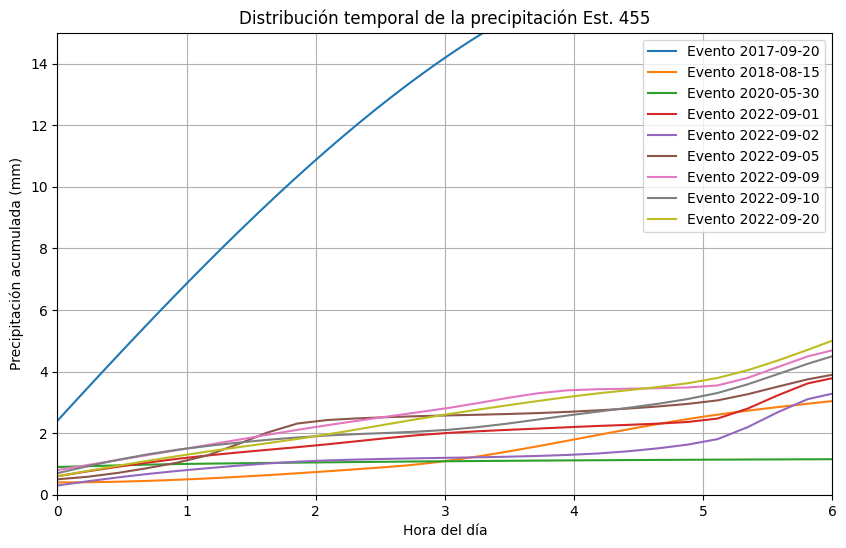

In [113]:
# 6. Plot one curve per event date
plt.figure(figsize=(10, 6))
for date in df3['Fecha2'].unique():
#for date in ['2018-09-21']:
    subset = df3[df3['Fecha2'] == date].copy()
    x = subset['Hora_decimal']
    y = subset['Acumulado']
    event_duration=x.max()-x.min()
    # Normalize x to the range 0–1 (0 to max_duration)
    x_scaled =(x - x.min()) / event_duration * max_duration  # Scaling
    # Smooth the curve
    if len(subset) >= 4:  # Spline needs at least 4 points for cubic
        from scipy.interpolate import PchipInterpolator
        spline = PchipInterpolator(x_scaled, y)
        x_new = np.linspace(0, event_duration, 100)
        y_smooth = spline(x_new)
        plt.plot(x_new, y_smooth, label=f'Evento {date}')
    else:
        plt.plot(x_scaled, y, label=f'Evento {date}', linestyle='dashed')  # fallback
        
plt.title("Distribución temporal de la precipitación Est. 455")
plt.xlabel("Hora del día")
plt.ylabel("Precipitación acumulada (mm)")
plt.xlim(0,6)
plt.ylim(0,15)
# Set y-axis ticks to be in 1-step intervals (customize as needed)
#plt.yticks(range(0, int(df3['Acumulado'].max()) + 1, 1))
plt.legend()
plt.grid(True)
plt.show()